In [1]:
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px

### Load data

In [2]:
data = pd.read_csv('billboard_24years_lyrics_spotify_with_genres.csv')

# Remove rows containing NaN values in the 'genre'
data = data.dropna(subset=['genre'])

In [3]:
## Make data frame with all data
data_all = data.copy()

In [4]:
## Make data frame with single entry per songurl
data_single = data.copy()

# Songs that appear more than once in the dataset
duplicated_songurls = data[data.duplicated(subset=['songurl'], keep=False)]['songurl'].unique()

for songurl in duplicated_songurls[:10]:
    rows = data[data['songurl'] == songurl]
    
    # Combine rows by collecting band_singer and url as lists of unique elements
    combined_band_singer = list(rows['band_singer'].unique())
    combined_url = list(rows['url'].unique())

    danceability = rows['danceability'].mean()
    energy = rows['energy'].mean()
    key = rows['key'].mean()
    loudness = rows['loudness'].mean()
    mode = rows['mode'].mean()
    speechiness = rows['speechiness'].mean()
    acousticness = rows['acousticness'].mean()
    instrumentalness = rows['instrumentalness'].mean()
    liveness = rows['liveness'].mean()
    valence = rows['valence'].mean()
    tempo = rows['tempo'].mean()
    duration_ms = rows['duration_ms'].mean()


    # Create a new row with combined information
    new_row = rows.iloc[0].copy()
    new_row['band_singer'] = combined_band_singer
    new_row['url'] = combined_url
    new_row['danceability'] = danceability
    new_row['energy'] = energy
    new_row['key'] = key
    new_row['loudness'] = loudness
    new_row['mode'] = mode
    new_row['speechiness'] = speechiness
    new_row['acousticness'] = acousticness
    new_row['instrumentalness'] = instrumentalness
    new_row['liveness'] = liveness
    new_row['valence'] = valence
    new_row['tempo'] = tempo
    new_row['duration_ms'] = duration_ms

    # Drop the original rows and append the new combined row
    data_single = data_single[data_single['songurl'] != songurl]
    data_single.loc[len(data_single)] = new_row

# Sort data_single by ranking
data_single = data_single.sort_values(by='ranking').reset_index(drop=True)

### Basic statistics

In [5]:
## Basic statistics of genres
df_genres = data_single[data_single['genre'].apply(bool)].reset_index(drop=True)

df_genres['genre'] = (
    df_genres['genre']
      .astype(str)
      .apply(lambda x: [g.strip() for g in x.split(',')] if ',' in x else [x.strip()])
)


Number of artists with genres: 3057
Average number of genres per artist: 2.1995420346745176
Total distinct genres: 327


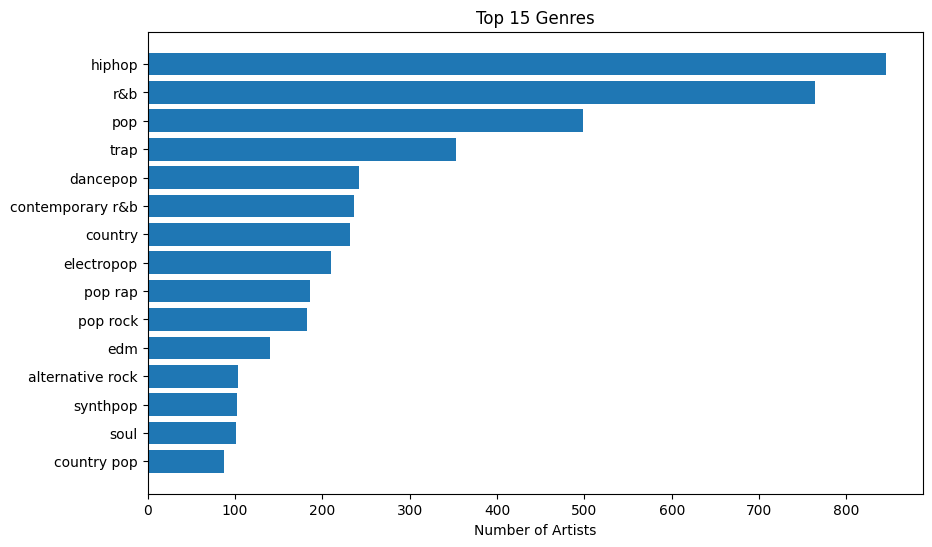

In [6]:

# --- Stats ---
num_artists_with_genres = len(df_genres)
avg_genres_per_artist = sum(len(genres) for genres in df_genres['genre']) / num_artists_with_genres
all_genres = [g for genres in df_genres['genre'] for g in genres]
num_distinct_genres = len(set(all_genres))
genre_counts = Counter(all_genres)

print("Number of artists with genres:", num_artists_with_genres)
print("Average number of genres per artist:", avg_genres_per_artist)
print("Total distinct genres:", num_distinct_genres)

# --- Histogram (top 15 genres) ---
if genre_counts:
    top = genre_counts.most_common(15)
    names, counts = zip(*top)
    plt.figure(figsize=(10,6))
    plt.barh(names[::-1], counts[::-1])
    plt.xlabel("Number of Artists")
    plt.title("Top 15 Genres")
    plt.show()

### Networks 

In [7]:
import networkx as nx
import pandas as pd
from collections import defaultdict, Counter
from multiprocessing import Pool, cpu_count

# Read emotion data
df_emo = pd.read_csv(
    'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt',
    sep='\t',
    header=None,
    names=['word', 'emotion', 'association']
)

In [8]:
## Remove genres with less than 5 artists
filtered_genres = {genre for genre, count in genre_counts.items() if count >= 5}
df_genres['genre'] = df_genres['genre'].apply(lambda genres: [g for g in genres if g in filtered_genres])
df_genres = df_genres[df_genres['genre'].apply(bool)].reset_index(drop=True)

In [9]:
## Function to map song lyrics to emotions and count frequency

def map_song_to_emotions_count(song_lyrics: str, word_to_emotions: dict) -> dict:
    """
    Map words in a song's lyrics to emotions and count frequency.
    Returns a dictionary: emotion -> count of words
    """
    words = song_lyrics.lower().split()
    emotion_counts = Counter()
    for word in words:
        if word in word_to_emotions:
            for emotion in word_to_emotions[word]:
                emotion_counts[emotion] += 1
    return dict(emotion_counts)

# --- Main execution ---
if __name__ == "__main__":
    # Step 1: Filter emotions with association == 1
    df_emo_ones = df_emo[df_emo['association'] == 1]

    # Step 2: Pre-build word -> emotion mapping
    word_to_emotions = defaultdict(list)
    for _, row in df_emo_ones.iterrows():
        word_to_emotions[row['word']].append(row['emotion'])

    # Step 3: Prepare song lyrics list
    songs_lyrics = data_single['lyrics'].tolist()

    # Step 4: Define worker for multiprocessing
    def worker_map_song(lyrics):
        return map_song_to_emotions_count(lyrics, word_to_emotions)

    # Step 5: Sequential processing (no parallelism)
    emotion_dicts = [worker_map_song(lyrics) for lyrics in songs_lyrics]

    # Step 6: Convert list of dicts to DataFrame and combine
    df_emotions = pd.DataFrame(emotion_dicts).fillna(0)
    df_songs_with_emotions = pd.concat([data_single.reset_index(drop=True), df_emotions.reset_index(drop=True)], axis=1)



In [22]:
# Get only first 10 rows
df_songs_with_emotions = df_songs_with_emotions.head(10)
df_songs_with_emotions[['genre', 'anger', 'joy', 'disgust']]

,genre,anger,joy,disgust
0,country pop,3.0,1.0,1.0
1,"trap, country trap, southern hiphop",1.0,1.0,0.0
2,"pop rap, trap",11.0,5.0,10.0
3,"pop, dancehall, tropical house",5.0,29.0,4.0
4,"alternative rock, postgrunge",10.0,3.0,10.0
5,"pop, folk, blueeyed soul",2.0,9.0,1.0
6,"funk, pop, soul, boogie, discopop, minneapolis...",18.0,7.0,1.0
7,"funk, pop, soul, boogie, discopop, minneapolis...",18.0,7.0,1.0
8,"country pop, hickhop, r&b",6.0,6.0,2.0
9,"pop, soul, neo soul, r&b",4.0,37.0,3.0


VIRKER IKKE KORREKT, DA GENRENE IKKE DELES RIGTIGT

In [ ]:
# List of emotion columns
emotion_cols = ['anticipation','fear','joy','positive','trust',
                'anger','disgust','negative','sadness','surprise']

cols_to_use = ['genre'] + emotion_cols

# If 'genre' contains lists, explode them so each genre is a hashable scalar for grouping
df_emotions_genre = df_songs_with_emotions[cols_to_use].explode('genre')

# Remove empty / NaN genres if any
df_emotions_genre = df_emotions_genre[df_emotions_genre['genre'].notna()]

## Get mean emotion counts per genre
gen = list(genre_counts.keys())

# Create a new DataFrame to hold the mean emotion counts per genre
df_emotions_by_genre = pd.DataFrame(columns=['genre'] + emotion_cols)
for g in gen:
    df_genre = df_emotions_genre[df_emotions_genre['genre'] == g]
    mean_values = df_genre[emotion_cols].mean()
    mean_values['genre'] = g
    df_emotions_by_genre = pd.concat([df_emotions_by_genre, pd.DataFrame([mean_values])], ignore_index=True)
    

# Group by genre and compute mean for each emotion
# df_emotions_by_genre = df_emotions_genre.groupby('genre')[emotion_cols].mean().reset_index()

# Show result

C:\Users\julie\AppData\Local\Temp\ipykernel_12660\737808226.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_emotions_by_genre = pd.concat([df_emotions_by_genre, pd.DataFrame([mean_values])], ignore_index=True)


,genre,anticipation,fear,joy,positive,trust,anger,disgust,negative,sadness,surprise
0,country pop,1.0,2.0,1.0,3.0,4.0,3.0,1.0,3.0,1.0,3.0
1,"trap, country trap, southern hiphop",0.0,0.0,1.0,1.0,5.0,1.0,0.0,1.0,0.0,0.0
2,"pop rap, trap",5.0,10.0,5.0,7.0,3.0,11.0,10.0,12.0,10.0,2.0
3,"pop, dancehall, tropical house",5.0,0.0,29.0,50.0,9.0,5.0,4.0,7.0,1.0,4.0
4,"alternative rock, postgrunge",1.0,11.0,3.0,10.0,2.0,10.0,10.0,18.0,13.0,1.0
5,"pop, folk, blueeyed soul",2.0,3.0,9.0,9.0,0.0,2.0,1.0,12.0,3.0,2.0
6,"funk, pop, soul, boogie, discopop, minneapolis...",11.0,11.0,7.0,9.0,11.0,18.0,1.0,43.0,31.0,6.0
7,"funk, pop, soul, boogie, discopop, minneapolis...",11.0,11.0,7.0,9.0,11.0,18.0,1.0,43.0,31.0,6.0
8,"country pop, hickhop, r&b",1.0,1.0,6.0,7.0,2.0,6.0,2.0,9.0,3.0,1.0
9,"pop, soul, neo soul, r&b",37.0,4.0,37.0,43.0,31.0,4.0,3.0,5.0,3.0,2.0


In [15]:
# Most dominant emotion per genre
df_emotions_by_genre['dominant_emotion'] = df_emotions_by_genre[emotion_cols].idxmax(axis=1)
df_emotions_by_genre[df_emotions_by_genre['genre'] == 'funk']


,genre,anticipation,fear,joy,positive,trust,anger,disgust,negative,sadness,surprise,dominant_emotion


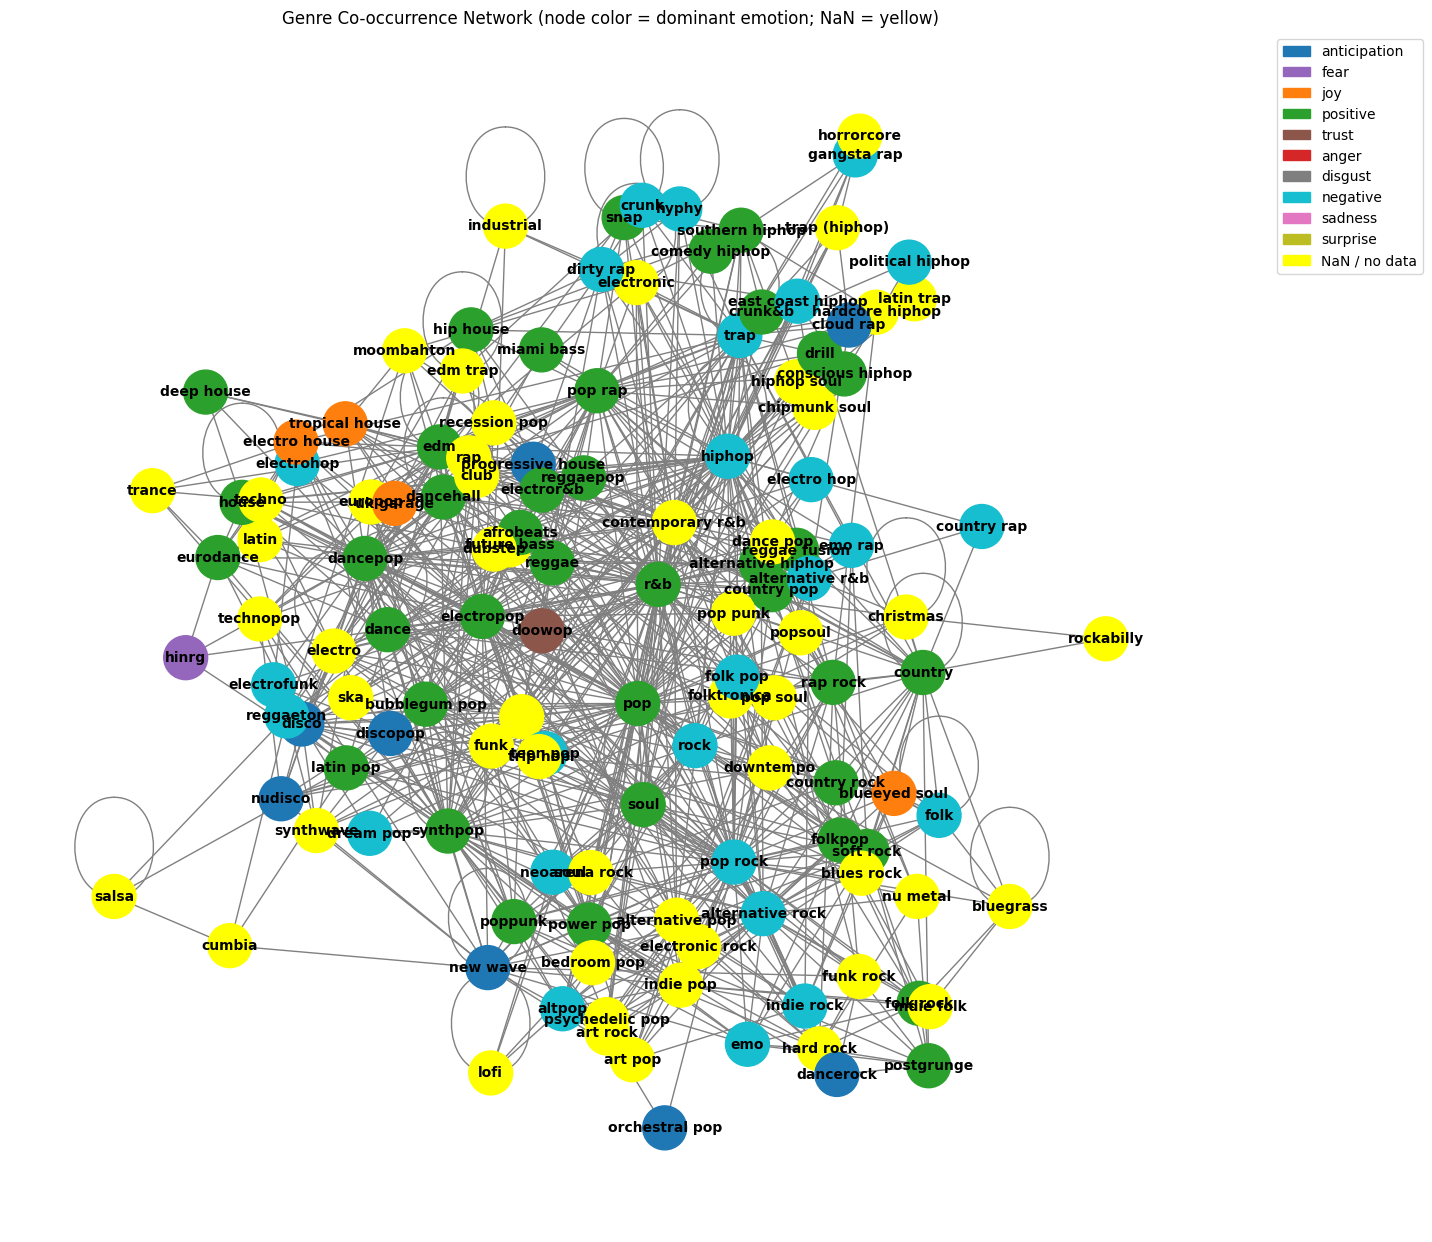

In [12]:
## Create graph with genres as nodes and links being the artist with both genres
G = nx.Graph()
for genres in df_genres['genre']:
    if len(genres) > 1:
        for i in range(len(genres)):
            for j in range(i + 1, len(genres)):
                genre1 = genres[i]
                genre2 = genres[j]
                if G.has_edge(genre1, genre2):
                    G[genre1][genre2]['weight'] += 1
                else:
                    G.add_edge(genre1, genre2, weight=1)

# Map emotions to colors
emotion_color_map = {
    'anticipation': '#1f77b4',
    'fear':         '#9467bd',
    'joy':          '#ff7f0e',
    'positive':     '#2ca02c',
    'trust':        '#8c564b',
    'anger':        '#d62728',
    'disgust':      '#7f7f7f',
    'negative':     '#17becf',
    'sadness':      '#e377c2',
    'surprise':     '#bcbd22'
}
nan_color = 'yellow'

# Build node color list based on dominant emotion per genre
node_colors = []
for node in G.nodes():
    row = df_emotions_by_genre[df_emotions_by_genre['genre'] == node]
    if not row.empty and pd.notna(row['dominant_emotion'].iloc[0]):
        dom = row['dominant_emotion'].iloc[0]
        node_colors.append(emotion_color_map.get(dom, nan_color))
    else:
        node_colors.append(nan_color)

# Draw the graph
plt.figure(figsize=(12, 12))
try:
    pos = nx.forceatlas2_layout(G, max_iter=1000)
except Exception:
    pos = nx.spring_layout(G, seed=42)

nx.draw(G, pos,
        with_labels=True,
        node_size=1000,
        node_color=node_colors,
        font_size=10,
        font_weight="bold",
        edge_color="gray")

# Optional: show a legend for emotions
patches = [mpatches.Patch(color=c, label=e) for e, c in emotion_color_map.items()]
patches.append(mpatches.Patch(color=nan_color, label='NaN / no data'))
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Genre Co-occurrence Network (node color = dominant emotion; NaN = yellow)")
plt.show()
